In [1]:
# set up the python
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs
import cmocean as cm
import cartopy.feature as cft
import cftime
import IPython.display
import sys, os, warnings

In [2]:
nc = xr.open_dataset('/g/data/v45/jn8053/CS2_combined_Southern_Ocean_2011-2016_regridded.nc')

In [3]:
nc

<xarray.Dataset>
Dimensions:   (Y: 121, X: 240, nbnd: 2, date: 72)
Coordinates:
  * Y         (Y) float64 90.0 88.5 87.0 85.5 84.0 ... -85.5 -87.0 -88.5 -90.0
  * X         (X) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * date      (date) int32 201101 201102 201103 201104 ... 201610 201611 201612
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds  (Y, nbnd) float64 ...
    lon_bnds  (X, nbnd) float64 ...
    gw        (Y) float64 ...
    area      (Y, X) float64 ...
    Area      (Y, X) float32 ...
    DOT       (date, Y, X) float32 ...
    MDT       (Y, X) float32 ...
    SLA       (date, Y, X) float32 ...
Attributes:
    Title:        CS2_combined_Southern_Ocean_2011-2016.nc
    Description:  Monthly merged dynamic ocean topography, sea level anomaly ...
    Projection::  Southern hemisphere SSM/I polar stereographic grid (https:/...
    Reference:    Armitage et al., Dynamic topography and sea level anomalies...
    history:      Tue Sep  8 11:16:36 2020: ncks --map weights.nc CS2_combine...
    NCO:          netCDF Operators version 4.9.2 (Homepage = http://nco.sf.ne...
    map_file:     weights.nc
    input_file:   CS2_combined_Southern_Ocean_2011-2016.nc

In [4]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33769/status,
Dashboard: /proxy/33769/status,Workers: 4
Total threads: 16,Total memory: 44.92 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36593,Workers: 4
Dashboard: /proxy/33769/status,Total threads: 16
Started: Just now,Total memory: 44.92 GiB
Comm: tcp://10.0.128.149:33619,Total threads: 4
Dashboard: /proxy/34895/status,Memory: 11.23 GiB
Nanny: tcp://127.0.0.1:38871,


In [5]:
#SSH variable in ACCESS-OM2 models
variable = 'eta_t'

# dates to match the AVISO record
start_time = '2011-01-01'
end_time = '2016-12-31'

In [6]:
# SSH observation
SSH_obs = nc.MDT/100.

In [7]:
session_2 = cc.database.create_session()

In [8]:
# 1 degree SSH
expt_1 = '1deg_jra55v13_iaf_spinup1_B1'  # 1-deg experiment
ssh1 = cc.querying.getvar(expt_1, 'eta_t', session_2, start_time=start_time, end_time=end_time)
ssh1 = ssh1.sel(time=slice(start_time, end_time)) # slice to the same time range as MOM6
ssh1_mean = ssh1.mean('time').load()

In [9]:
# 0.25 degree mean SSH
expt_2 = '025deg_jra55_iaf_omip2_cycle1'  # 0.25-deg experiment
ssh025 = cc.querying.getvar(expt_2, variable, session_2, start_time=start_time, end_time=end_time)
ssh025 = ssh025.sel(time=slice(start_time, end_time)) # slice to the same time range as MOM6
ssh025_mean = ssh025.mean('time').load()

In [12]:
# 0.1 degree mean SSH
expt_3 = '01deg_jra55v13_iaf'  # 0.1-deg experiment
# -82 to -37
ssh01 = cc.querying.getvar(expt_3, variable, session_2, start_time=start_time, end_time=end_time)
ssh01 = ssh01.sel(time=slice(start_time, end_time)).sel(yt_ocean = slice(-82,-37))
ssh01_mean = ssh01.mean('time').load()

In [16]:
ssh1

<xarray.DataArray 'eta_t' (time: 72, yt_ocean: 300, xt_ocean: 360)>
dask.array<getitem, shape=(72, 300, 360), dtype=float32, chunksize=(1, 300, 360), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yt_ocean  (yt_ocean) float64 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * time      (time) datetime64[ns] 2011-01-16T12:00:00 ... 2016-12-16T12:00:00
Attributes: (12/13)
    long_name:      surface height on T cells [Boussinesq (volume conserving)...
    units:          meter
    valid_range:    [-1000.  1000.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    ...             ...
    ncfiles:        ['/g/data/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spi...
    contact:        Abhishek Savita
    email:          Abhishek.Savita@csiro.au
    created:        2019-04-12
    description:    1 degree ACCESS-OM2 global model configuration under inte...
    notes:          Source code: https://github.com/COSIMA/access-om2/release...

In [20]:
x1 = ssh1.xt_ocean
y1 = ssh1.yt_ocean
x1

<xarray.DataArray 'xt_ocean' (xt_ocean: 360)>
array([-279.5, -278.5, -277.5, ...,   77.5,   78.5,   79.5])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
Attributes:
    long_name:       tcell longitude
    units:           degrees_E
    cartesian_axis:  X

Text(0, 0.5, 'Mean SSH (m)')

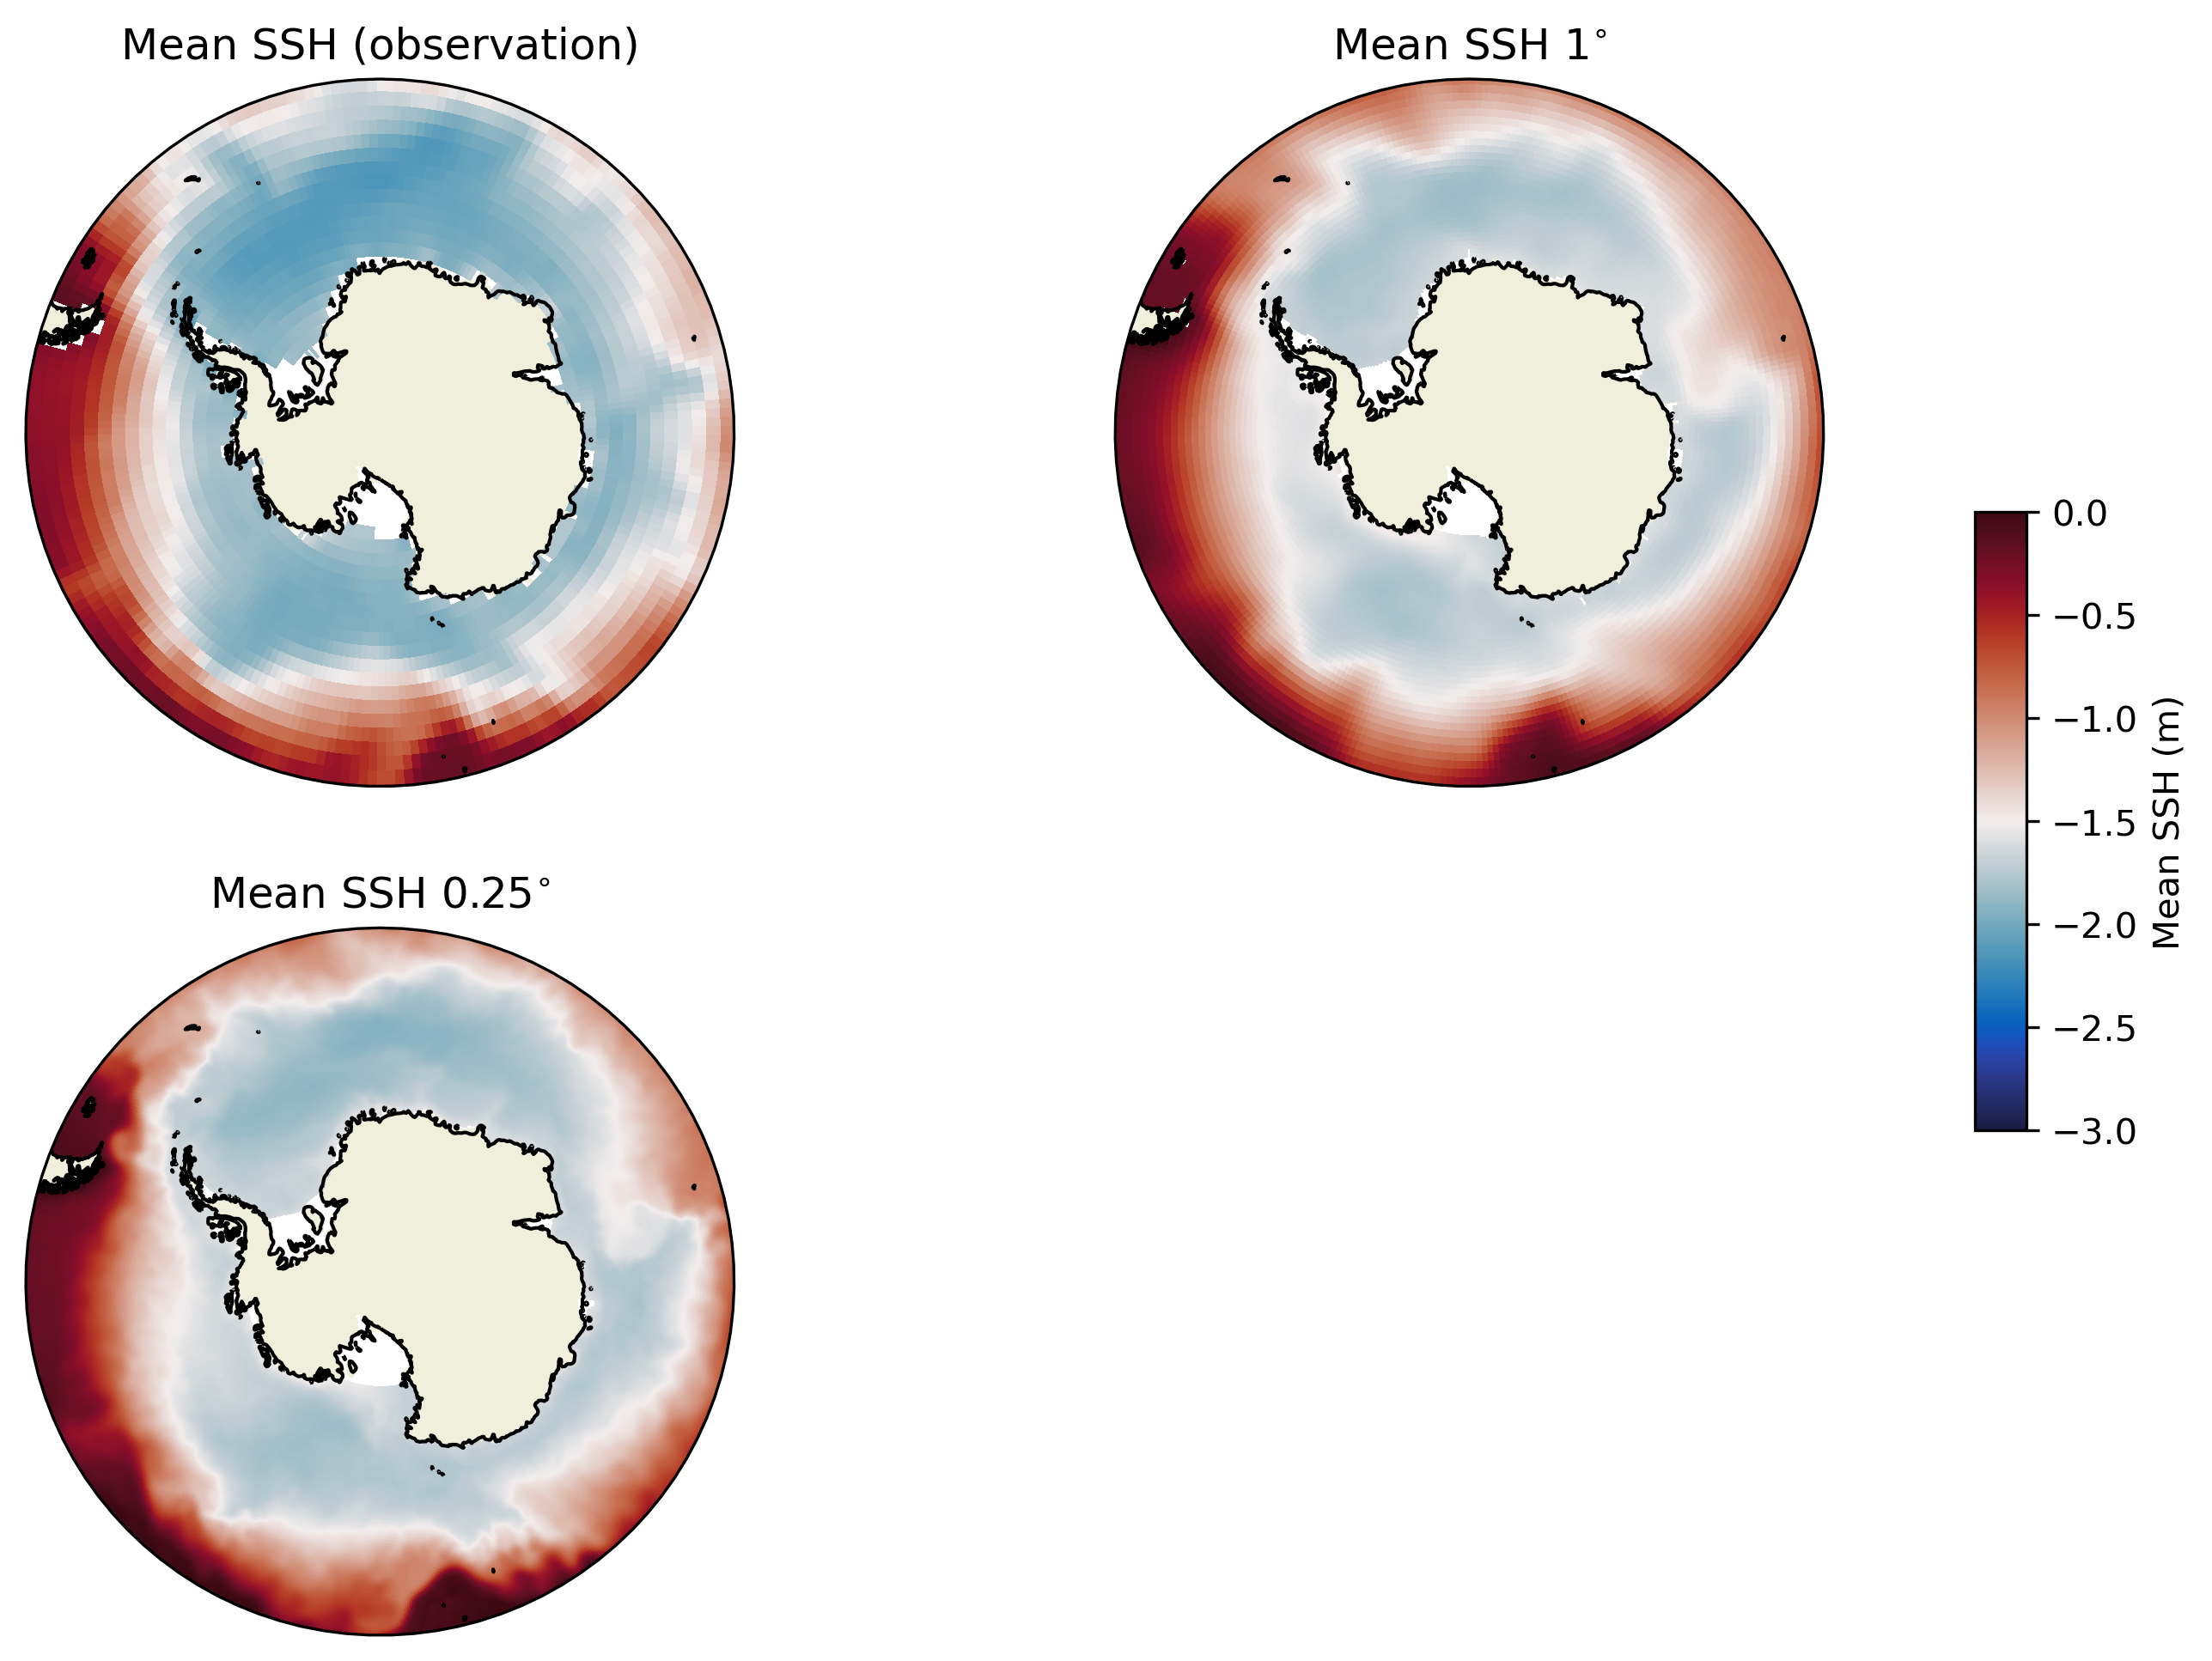

In [22]:
# observation
projection=ccrs.SouthPolarStereo()
fig = plt.figure(figsize=(10, 8), dpi=300)
ax = plt.subplot(2, 2, 1, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280, 80, -82, -50], crs=ccrs.PlateCarree())
ax.set_title('Mean SSH 1$^{\circ}$')

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = SSH_obs.plot(vmin=-3,vmax=0,transform=ccrs.PlateCarree(),cmap=cm.cm.balance,add_colorbar=False)
ax.set_title('Mean SSH (observation)')

# 1 deg 
ax = plt.subplot(2, 2, 2, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280, 80, -82, -50], crs=ccrs.PlateCarree())
ax.set_title('Mean SSH 1$^{\circ}$')

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = ssh1_mean.plot(vmin=-3,vmax=0,transform=ccrs.PlateCarree(),cmap=cm.cm.balance,add_colorbar=False)
ax.set_title('Mean SSH 1$^{\circ}$')

# 0.25 deg
ax = plt.subplot(2, 2, 3, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280, 80, -82, -50], crs=ccrs.PlateCarree())
ax.set_title('Mean SSH 0.25$^{\circ}$')

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
p1 = ssh025_mean.plot(vmin=-3,vmax=0,transform=ccrs.PlateCarree(),cmap=cm.cm.balance,add_colorbar=False)
ax.set_title('Mean SSH 0.25$^{\circ}$')

# add the colorbar
ax = plt.axes([0.92, 0.37, 0.02, 0.3])
cb = plt.colorbar(p1, cax=ax, orientation='vertical')
cb.ax.set_ylabel('Mean SSH (m)')

Text(0, 0.5, 'Mean SSH (m)')

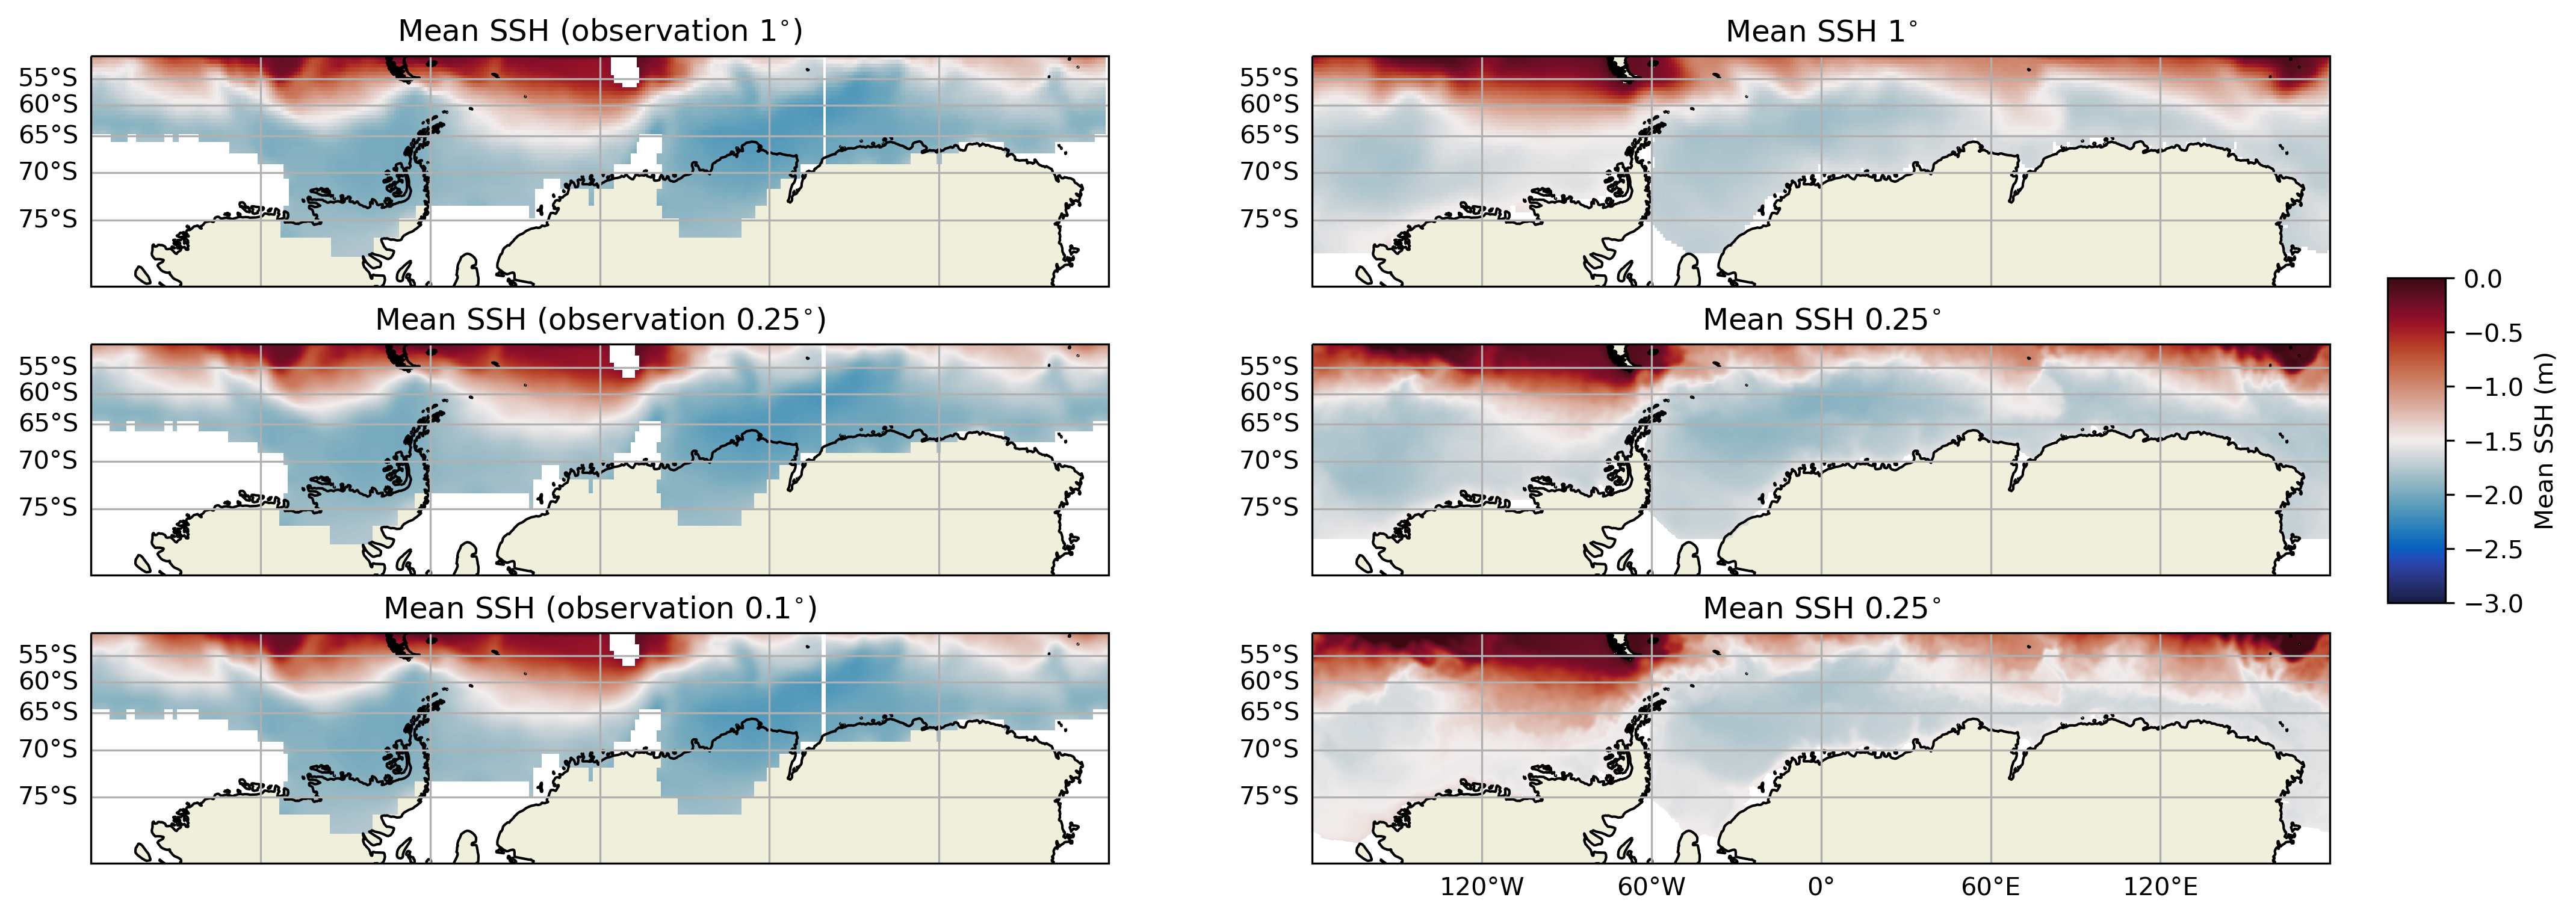

In [25]:
# observation 1 deg regrid
projection=ccrs.Mercator(min_latitude=-80.0, max_latitude=-50.0)
fig = plt.figure(figsize=(16, 6), dpi=300)
ax = plt.subplot(3, 2, 1, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([0, 350, -80, -50], crs=ccrs.PlateCarree())
lb =ax.gridlines(draw_labels=True)
lb.xlabels_top = False
lb.xlabels_bottom = False
lb.ylabels_right = False
p1 = SSH_obs1.plot(vmin=-3,vmax=0,transform=ccrs.PlateCarree(),cmap=cm.cm.balance,add_colorbar=False)
ax.set_title('Mean SSH (observation 1$^{\circ}$)')

# 1 deg 
ax = plt.subplot(3, 2, 2, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280, 70, -82, -50], crs=ccrs.PlateCarree())
ax.set_title('Mean SSH 1$^{\circ}$')
lb =ax.gridlines(draw_labels=True)
lb.xlabels_top = False
lb.xlabels_bottom = False
lb.ylabels_right = False
p1 = ssh1_mean.plot(vmin=-3,vmax=0,transform=ccrs.PlateCarree(),cmap=cm.cm.balance,add_colorbar=False)
ax.set_title('Mean SSH 1$^{\circ}$')

# observation 0.25 deg regrid
ax = plt.subplot(3, 2, 3, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([0, 350, -80, -50], crs=ccrs.PlateCarree())
lb =ax.gridlines(draw_labels=True)
lb.xlabels_top = False
lb.xlabels_bottom = False
lb.ylabels_right = False
p1 = SSH_obs025.plot(vmin=-3,vmax=0,transform=ccrs.PlateCarree(),cmap=cm.cm.balance,add_colorbar=False)
ax.set_title('Mean SSH (observation 0.25$^{\circ}$)')

# 0.25 deg
ax = plt.subplot(3, 2, 4, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280, 70, -82, -50], crs=ccrs.PlateCarree())
ax.set_title('Mean SSH 0.25$^{\circ}$')
lb =ax.gridlines(draw_labels=True)
lb.xlabels_top = False
lb.xlabels_bottom = False
lb.ylabels_right = False
p1 = ssh025_mean.plot(vmin=-3,vmax=0,transform=ccrs.PlateCarree(),cmap=cm.cm.balance,add_colorbar=False)
ax.set_title('Mean SSH 0.25$^{\circ}$')

# observation 0.1 deg regrid
ax = plt.subplot(3, 2, 5, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([0, 350, -80, -50], crs=ccrs.PlateCarree())
lb =ax.gridlines(draw_labels=True)
lb.xlabels_top = False
lb.xlabels_bottom = False
lb.ylabels_right = False
p1 = SSH_obs01.plot(vmin=-3,vmax=0,transform=ccrs.PlateCarree(),cmap=cm.cm.balance,add_colorbar=False)
ax.set_title('Mean SSH (observation 0.1$^{\circ}$)')

# 0.1 deg
ax = plt.subplot(3, 2, 6, projection=projection)
ax.coastlines(resolution='50m')
ax.add_feature(cft.LAND)
ax.set_extent([-280, 70, -82, -50], crs=ccrs.PlateCarree())
ax.set_title('Mean SSH 0.25$^{\circ}$')
lb =ax.gridlines(draw_labels=True)
lb.xlabels_top = False
lb.ylabels_right = False
p1 = ssh01_mean.plot(vmin=-3,vmax=0,transform=ccrs.PlateCarree(),cmap=cm.cm.balance,add_colorbar=False)
ax.set_title('Mean SSH 0.25$^{\circ}$')
# add the colorbar
ax = plt.axes([0.92, 0.37, 0.02, 0.3])
cb = plt.colorbar(p1, cax=ax, orientation='vertical')
cb.ax.set_ylabel('Mean SSH (m)')